The last part of moddeling with (univariate spline) GAMs is choosing the smoothing parameter \\( \lambda \\). This post will elaborate on this, using the `scikit-learn` `GriddSearchCV` functionality to do this. We'll use `pyGAM` to do the heavy lifting, and we'll use the same data as the last post

Text(0,0.5,'Acceleration')

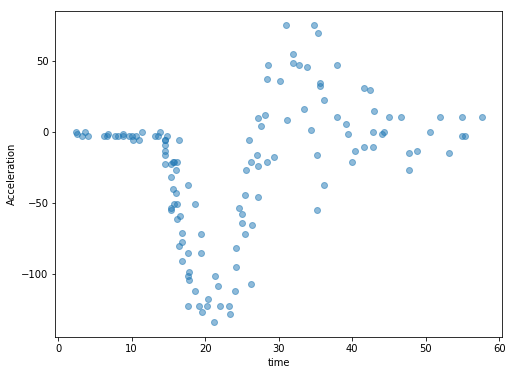

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import patsy
import scipy as sp
import seaborn as sns
from statsmodels import api as sm

%matplotlib inline

df = pd.read_csv('mcycle.csv')
df = df.drop('Unnamed: 0', axis=1)

min_time = df.times.min()
max_time = df.times.max()

fig, ax = plt.subplots(figsize=(8, 6))
blue = sns.color_palette()[0]
ax.scatter(df.times, df.accel, c=blue, alpha=0.5)
ax.set_xlabel('time')
ax.set_ylabel('Acceleration')

In [2]:
def splines(df):

    def R(x, z):
        return ((z - 0.5)**2 - 1 / 12) * ((x - 0.5)**2 - 1 / 12) / 4 - ((np.abs(x - z) - 0.5)**4 - 0.5 * (np.abs(x - z) - 0.5)**2 + 7 / 240) / 24

    R = np.frompyfunc(R, 2, 1)

    def R_(x):
        return R.outer(x, knots).astype(np.float64)

    y, X = patsy.dmatrices('accel ~ times + R_(times)', data=df)

    knots = df.times.quantile(np.linspace(0, 1, q))
    
def GAM(df, q=20, gamma=1.0):    

    S = np.zeros((q + 2, q + 2))
    S[2:, 2:] = R_(knots)

    B = np.zeros_like(S)
    B[2:, 2:] = np.real_if_close(sp.linalg.sqrtm(S[2:, 2:]), tol=10**8)

    def fit(y, X, B, lambda_=gamma):
        # build the augmented matrices
        y_ = np.vstack((y, np.zeros((q + 2, 1))))
        X_ = np.vstack((X, np.sqrt(lambda_) * B))
    
        return sm.OLS(y_, X_).fit()
    
    return fit(X, y, b, lambda_)

In [3]:
min_time = df.times.min()
max_time = df.times.max()

plot_x = np.linspace(min_time, max_time, 100)
plot_X = patsy.dmatrix('times + R_(times)', {'times': plot_x})

results = GAM(df)

fig, ax = plt.subplots(figsize=(8, 6))
blue = sns.color_palette()[0]
ax.scatter(df.times, df.accel, c=blue, alpha=0.5)
ax.plot(plot_x, results.predict(plot_X))
ax.set_xlabel('time')
ax.set_ylabel('accel')
ax.set_title(r'$\lambda = {}$'.format(1.0))

PatsyError: Error evaluating factor: NameError: name 'R_' is not defined
    times + R_(times)
            ^^^^^^^^^